In [227]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statsmodels as sm
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import *
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
warnings.filterwarnings("ignore")

In [465]:
df = pd.read_csv('./dane/LR_dane_treningowe_testowe.csv')
df.head(1)

,Unnamed: 0,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY,AGE_GROUP
0,0,63581743,0,16MAR39,60.0,0,11.0,67.349,0,0.0,...,1,4.461,2,0,3,0.0,18.0,0,1,5


In [466]:
#https://www.statology.org/likelihood-ratio-test-in-python/
#df.dtypes

def to_categorical(variable):
    lp = 0
    for i in df[variable].unique():
        lp += 1
        df[variable][df[variable] == i] = lp
    return df[variable]#.astype(int)

In [467]:


df['EDUCATION'] = to_categorical('EDUCATION')
df['OCCUPATION'] = to_categorical('OCCUPATION')


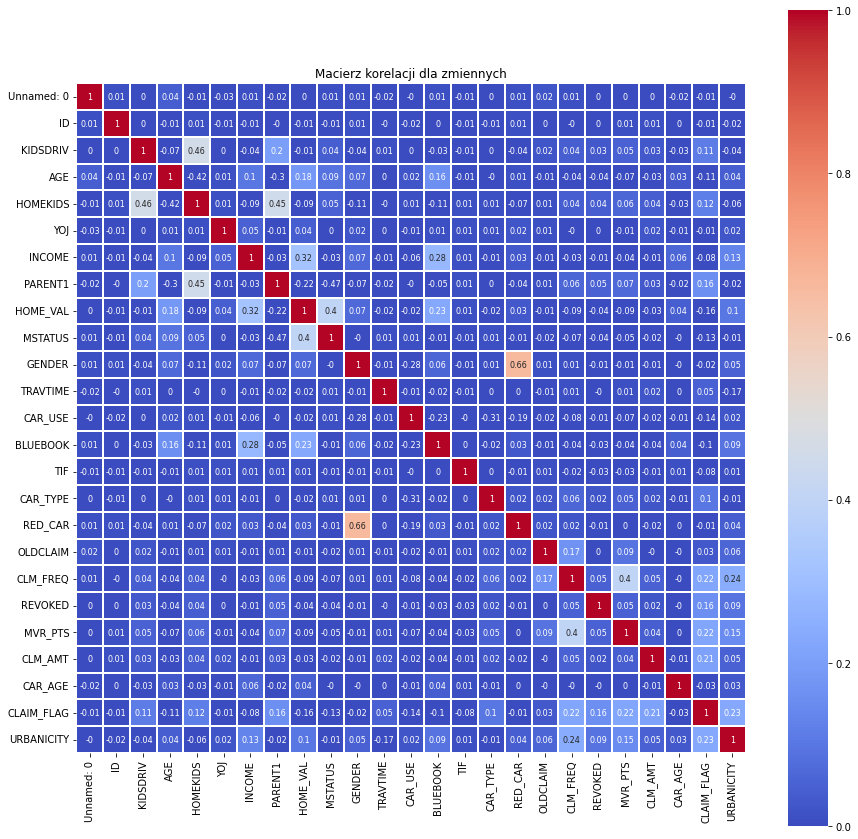

In [468]:
fig=plt.figure(figsize = (15, 15))
ax1 = fig.add_subplot(111)
corr = df.iloc[ : , : -1].corr().round(2)
sns.heatmap(corr, vmin = 0.0, vmax = 1, square=True, linewidths = 0.1, annot = True, annot_kws={"size" : 8}, cmap = "coolwarm")
plt.title("Macierz korelacji dla zmiennych")
plt.show()

In [469]:
w = df['CLAIM_FLAG'].value_counts() / df.shape[0]
w

0    0.733443
1    0.266557
Name: CLAIM_FLAG, dtype: float64

In [470]:
df['sample_weights'] = 0
df['sample_weights'][df['CLAIM_FLAG'] == 0] = w[1]
df['sample_weights'][df['CLAIM_FLAG'] == 1] = w[0]

In [471]:
x_cols = ['INCOME','HOME_VAL','CAR_AGE']

In [472]:
for col in x_cols:
    std = df[col].std()
    mean = df[col].mean()
    outliers = (df[col] > ((2 * std) + mean)) | ((mean - (2 * std)) > df[col])
    print( f"W zmiennej {col} zidentyfikowano {outliers.sum()} rekordów ({round(outliers.sum() / df[col].notna().sum(),2)}%) jako wartości odstające")
    df['outlier'] = outliers
    df = df[df['outlier'] == False]

W zmiennej INCOME zidentyfikowano 789 rekordów (0.08%) jako wartości odstające
W zmiennej HOME_VAL zidentyfikowano 223 rekordów (0.02%) jako wartości odstające
W zmiennej CAR_AGE zidentyfikowano 563 rekordów (0.06%) jako wartości odstające


In [473]:
df['Nrow'] = [x for x in range(df.shape[0])] 

In [474]:
ids = random.sample(list(df['Nrow'].values), int(.70*df.shape[0]))
df_train = df[df['Nrow'].isin(ids)]
df_test = df[~df['Nrow'].isin(ids)]

Text(0, 0.5, 'Liczebność')

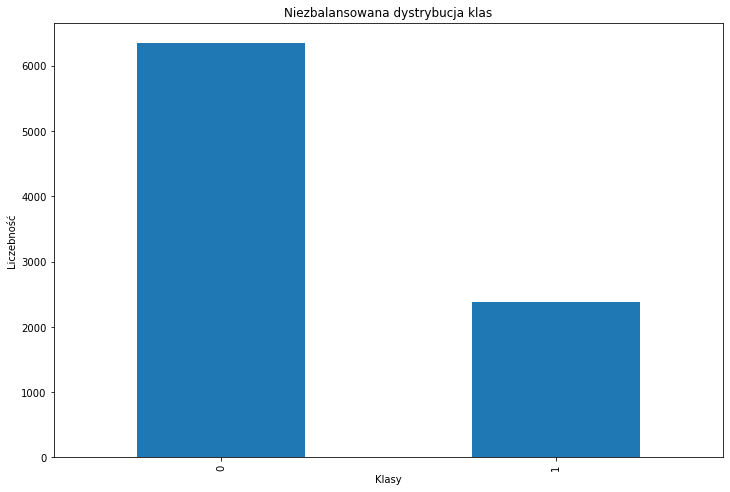

In [475]:
plt.figure(figsize=(12, 8))
df.CLAIM_FLAG.value_counts().nlargest(10).sort_values(ascending=False).plot.bar()
plt.title("Niezbalansowana dystrybucja klas")
plt.xlabel("Klasy")
plt.ylabel("Liczebność")

In [476]:
import scipy
df.columns

Index(['Unnamed: 0', 'ID', 'KIDSDRIV', 'BIRTH', 'AGE', 'HOMEKIDS', 'YOJ',
       'INCOME', 'PARENT1', 'HOME_VAL', 'MSTATUS', 'GENDER', 'EDUCATION',
       'OCCUPATION', 'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE',
       'RED_CAR', 'OLDCLAIM', 'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CLM_AMT',
       'CAR_AGE', 'CLAIM_FLAG', 'URBANICITY', 'AGE_GROUP', 'sample_weights',
       'outlier', 'Nrow'],
      dtype='object')

In [477]:
df_train.iloc[:,6:].head(2)

,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,...,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY,AGE_GROUP,sample_weights,outlier,Nrow
1,11.0,91.449,0,257.252,0,1,2,2,22,0,...,0,0,0.0,1.0,0,1,3,0.266557,False,1
3,10.0,16.039,0,124.191,1,0,2,4,5,1,...,0,3,0.0,10.0,0,1,2,0.266557,False,3


Optimization terminated successfully.
         Current function value: 0.463513
         Iterations 7
CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS +YOJ+ INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP
Optimization terminated successfully.
         Current function value: 0.463447
         Iterations 7


CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS + INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+AGE_GROUP
Optimization terminated successfully.
         Current function value: 0.500181
         Iterations 6
Nie usuwaj zmiennej 2 musi być dodana


CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS + INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+URBANICITY+AGE_G

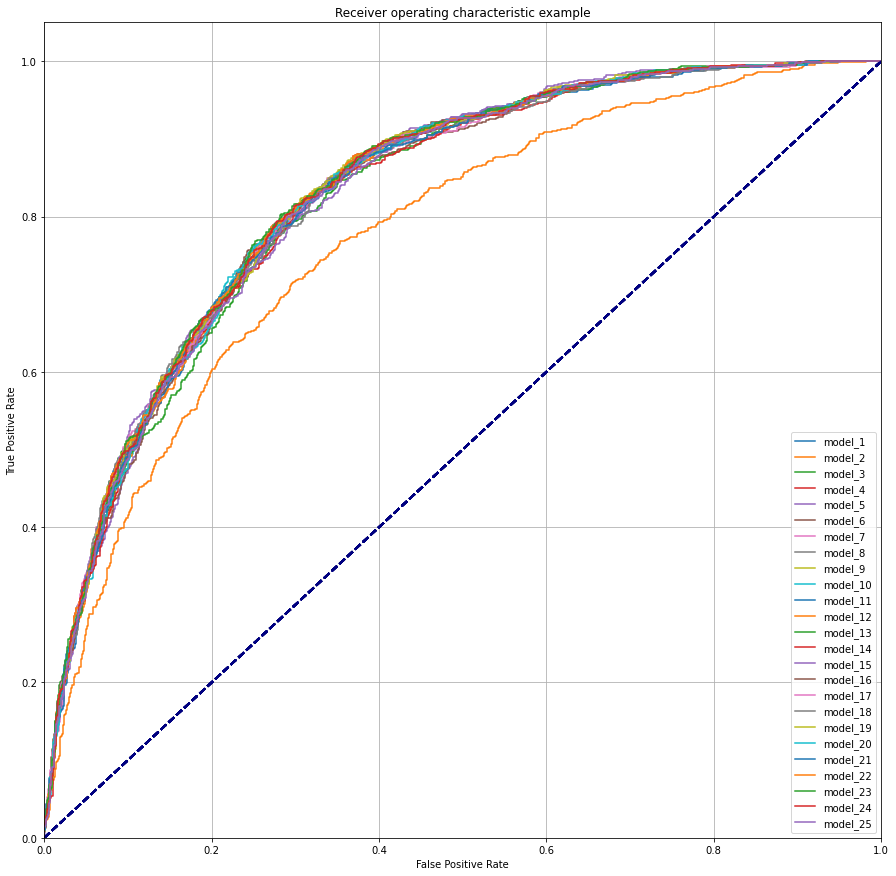

In [504]:
full_ll = smf.logit(formula ='CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS + INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP', data = df_train, sample_weight = df_train['sample_weights']).fit()

predictors = ['CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS +YOJ+ INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
              
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS + INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+AGE_GROUP',
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS + INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+URBANICITY+AGE_GROUP',
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS + INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS + INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+CAR_AGE+URBANICITY+AGE_GROUP',
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS + INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS +YOJ+ INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS +YOJ+ INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS +YOJ+ INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+TIF+CAR_TYPE+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS +YOJ+ INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+TIF+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS +YOJ+ INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS +YOJ+ INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS +YOJ+ INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS +YOJ+ INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS +YOJ+ INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION +  TRAVTIME + CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS +YOJ+ INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER +  OCCUPATION + TRAVTIME + CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS +YOJ+ INCOME + PARENT1 + HOME_VAL + MSTATUS + EDUCATION + OCCUPATION + TRAVTIME + CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS +YOJ+ INCOME + PARENT1 + HOME_VAL +  GENDER + EDUCATION + OCCUPATION + TRAVTIME + CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS +YOJ+ INCOME + PARENT1 +  MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME + CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS +YOJ+ INCOME + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME +CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
              'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS +YOJ + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
             'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS + INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
             'CLAIM_FLAG ~ KIDSDRIV + AGE  +YOJ+ INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
             'CLAIM_FLAG ~ KIDSDRIV + HOMEKIDS +YOJ+ INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP',
             'CLAIM_FLAG ~  AGE+ HOMEKIDS +YOJ+ INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + TRAVTIME+CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP']
             


plt.figure(figsize=(15,15))
n = 0
for v in predictors:
    n+=1
    print(v)
    reduced_model = smf.logit(formula = f'{v}', data = df_train,sample_weight = df_train['sample_weights'] ).fit()

    LR_statistic = -2*(reduced_model.llf-full_ll.llf)
    
    p_val = scipy.stats.chi2.sf(LR_statistic, 2)
    
    if p_val < 0.05:
        print(f"Nie usuwaj zmiennej {n} musi być dodana")
    
    #print(LR_statistic)
    print('\n')
    
    y_pred = reduced_model .predict(df_test)
    fpr, tpr, _ = roc_curve(df_test["CLAIM_FLAG"], y_pred)
    roc_auc = auc(fpr, tpr)
    lw = 2
    plt.plot(fpr, tpr, label=f'model_{n}')
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.grid()
plt.show()

In [498]:
LR_statistic

9.230296981704669

In [ ]:
# standaryzacja

In [435]:
#min max

df.head()

,Unnamed: 0,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY,AGE_GROUP,sample_weights,outlier,Nrow
0,0,63581743,0,16MAR39,60.0,0,11.0,67.349,0,0.000,...,0,3,0.0,18.0,0,1,5,0.266557,False,0
1,1,132761049,0,21JAN56,43.0,0,11.0,91.449,0,257.252,...,0,0,0.0,1.0,0,1,3,0.266557,False,1
2,2,921317019,0,18NOV51,48.0,0,11.0,52.881,0,0.000,...,0,2,0.0,10.0,0,1,4,0.266557,False,2
3,3,727598473,0,05MAR64,35.0,1,10.0,16.039,0,124.191,...,0,3,0.0,10.0,0,1,2,0.266557,False,3
5,5,743146596,0,17MAY49,50.0,0,-99.0,114.986,0,243.925,...,1,3,0.0,17.0,0,1,4,0.266557,False,4


In [436]:
## OpracowaćCLM_FREQ, , CLM_AMT, 

Text(0, 0.5, 'Liczebność')

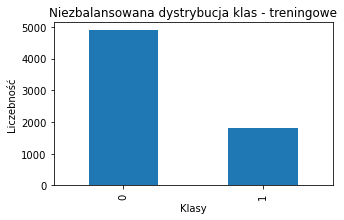

In [340]:
plt.figure(figsize=(5, 3))
df_train.CLAIM_FLAG.value_counts().nlargest(10).sort_values(ascending=False).plot.bar()
plt.title("Niezbalansowana dystrybucja klas - treningowe")
plt.xlabel("Klasy")
plt.ylabel("Liczebność")


MLE -  Maximum Likelihood Estimation

In [505]:
m1 = smf.logit(formula = 'CLAIM_FLAG ~ KIDSDRIV + AGE+ HOMEKIDS +YOJ+ INCOME + PARENT1 + HOME_VAL + MSTATUS + GENDER + EDUCATION + OCCUPATION + CAR_USE+BLUEBOOK+TIF+CAR_TYPE+RED_CAR+OLDCLAIM+CLM_FREQ+REVOKED+MVR_PTS+CAR_AGE+URBANICITY+AGE_GROUP', data = df_train, sample_weight = df_train['sample_weights']).fit()

Optimization terminated successfully.
         Current function value: 0.466812
         Iterations 7


In [506]:
print(m1.summary().tables[0])

                           Logit Regression Results                           
Dep. Variable:             CLAIM_FLAG   No. Observations:                 6106
Model:                          Logit   Df Residuals:                     6072
Method:                           MLE   Df Model:                           33
Date:                Wed, 15 Jun 2022   Pseudo R-squ.:                  0.2039
Time:                        16:38:19   Log-Likelihood:                -2850.4
converged:                       True   LL-Null:                       -3580.5
Covariance Type:            nonrobust   LLR p-value:                3.785e-286


In [507]:
full_ll = m1.llf
full_ll

-2850.3512467304313

In [508]:
print(m1.summary().tables[1])

                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.0765      0.388     -5.358      0.000      -2.836      -1.317
EDUCATION[T.2]      0.3077      0.235      1.311      0.190      -0.152       0.768
EDUCATION[T.3]      0.0089      0.218      0.041      0.968      -0.419       0.437
EDUCATION[T.4]      0.2677      0.253      1.060      0.289      -0.227       0.763
EDUCATION[T.5]      0.0768      0.194      0.395      0.693      -0.304       0.458
OCCUPATION[T.2]     0.1915      0.131      1.459      0.145      -0.066       0.449
OCCUPATION[T.3]    -0.8984      0.150     -5.970      0.000      -1.193      -0.603
OCCUPATION[T.4]     0.1762      0.138      1.281      0.200      -0.093       0.446
OCCUPATION[T.5]    -0.6614      0.360     -1.838      0.066      -1.367       0.044
OCCUPATION[T.6]    -0.0026      0.189     -0.014      0.989      -0.374     

In [516]:
p = 0.5
y_pred = m1.predict(df_test)
y_pred_kwant = y_pred.copy()
y_pred_kwant[y_pred_kwant >= p] = 1
y_pred_kwant[y_pred_kwant < p] = 0

In [517]:
print(confusion_matrix(df_test["CLAIM_FLAG"], y_pred_kwant.astype(np.int32)))

[[1761  145]
 [ 417  294]]


In [518]:
y_pred_kwant.unique()

array([0., 1.])

In [519]:
acc = round(accuracy_score(y_pred_kwant, df_test["CLAIM_FLAG"]),2)*100
b_acc = round(balanced_accuracy_score(y_pred_kwant,df_test["CLAIM_FLAG"]),2)*100

print(f'Dokładność wynosi {acc} %, ale bieda')
print(f'Zbalansowana dokładność wynosi {b_acc} %, żenada')

Dokładność wynosi 79.0 %, ale bieda
Zbalansowana dokładność wynosi 74.0 %, żenada


In [520]:
print(f'Area Under Curve: {roc_auc_score(y_pred_kwant, df_test["CLAIM_FLAG"])}')
print(f'Recall score: {recall_score(y_pred_kwant, df_test["CLAIM_FLAG"])}')

Area Under Curve: 0.7391219086704695
Recall score: 0.6697038724373576


In [521]:
fpr, tpr, _ = roc_curve(df_test["CLAIM_FLAG"], y_pred)
roc_auc = auc(fpr, tpr)

No handles with labels found to put in legend.


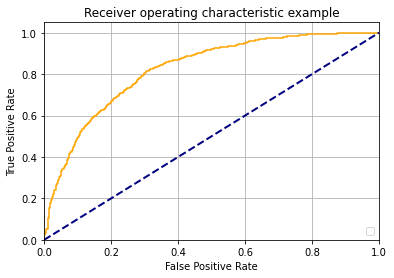

In [522]:
plt.figure()
lw = 2
plt.plot(fpr, tpr,color="orange")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.grid()

plt.show()